In [12]:
import matplotlib.pyplot as plt
from torch.optim import LBFGS, Adam
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

Text(0.5, 1.0, 'Slice of u(x,v) at t=0')

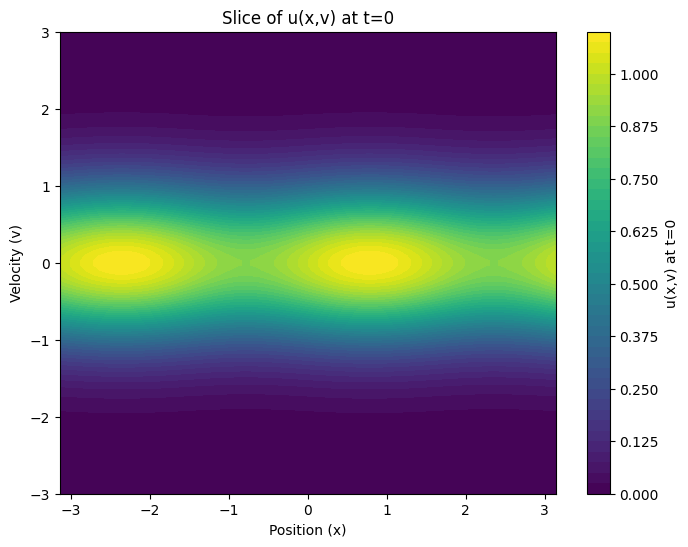

In [13]:
alpha = 0.1
t = np.linspace(0, 2*np.pi, 100)
x = np.linspace(-np.pi, np.pi, 100)
v = np.linspace(-3, 3, 100)

T, X, V = np.meshgrid(t, x, v, indexing='ij')

# Get slice when t = 0
u_slice_t0 = np.exp(-V[0, :, :]**2) * (1 + alpha * np.sin(2*X[0, :, :]))

plt.figure(figsize=(8, 6))
plt.contourf(x, v, u_slice_t0.T, levels=50, cmap='viridis')
plt.colorbar(label='u(x,v) at t=0')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Slice of u(x,v) at t=0')

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def u0(x, v):
    return torch.exp(-v**2) * (1 + alpha * torch.sin(2*x))

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x, v):
        inputs = torch.cat([t, x, v], dim=1)
        return self.net(inputs)
    
model = PINN().to(device)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')


X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
V_tensor = torch.tensor(V, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
T_tensor = torch.tensor(T, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)


loss_track = []

def closure():
    global loss_track
    model.train()
    pred_res = model(T_tensor, X_tensor, V_tensor)
    
    pred_init = model(torch.zeros_like(X_tensor), X_tensor, V_tensor)
    
    pred_left = model(T_tensor, -np.pi*torch.ones_like(X_tensor), V_tensor)
    pred_right = model(T_tensor, np.pi*torch.ones_like(X_tensor), V_tensor)
    
    # compute u_t, v * u_x for vlasov eqn
    
    u_t = torch.autograd.grad(pred_res, T_tensor, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
    u_x = torch.autograd.grad(pred_res, X_tensor, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
    v_u_x = V_tensor * u_x
    
    loss_res = torch.mean((u_t + v_u_x)**2)
    loss_ic = torch.mean((pred_init - u0(X_tensor, V_tensor))**2)
    loss_bc = torch.mean((pred_left - pred_right)**2)
    loss = loss_res + loss_ic + loss_bc
    
    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    
    optim.zero_grad()
    loss.backward()
    return loss


progress_bar = tqdm(range(500))

for i in progress_bar:
    optim.step(closure)
    last_loss = loss_track[-1]
    progress_bar.set_postfix({
        "res": f"{last_loss[0]:.6f}",
        "ic": f"{last_loss[1]:.6f}",
        "bc": f"{last_loss[2]:.6f}",
    })

  1%|          | 5/500 [03:26<5:41:00, 41.33s/it, res=0.000077, ic=0.000745, bc=0.000065]


KeyboardInterrupt: 